# AR and MA models for Tractor Sales

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import pmdarima as pm # Auto ARIMA
from sklearn.metrics import mean_squared_error

#### 1. Import and prepare the dataset (cf. TractorSales.ipynb).
Differncing is not required.

In [2]:
# Loading the Data
df = pd.read_csv('TractorSales.csv', sep=',')
df['date'] = pd.date_range(start='2003-01-01', freq='MS', periods=len(df))
df['sold'] = df.iloc[:,1]
df['log_sold'] = np.log(df['sold'])
tractor = df.copy().set_index('date')[['sold', 'log_sold']]
tractor

,sold,log_sold
date,,
2003-01-01,141,4.948760
2003-02-01,157,5.056246
2003-03-01,185,5.220356
2003-04-01,199,5.293305
2003-05-01,203,5.313206
...,...,...
2014-08-01,848,6.742881
2014-09-01,640,6.461468
2014-10-01,581,6.364751


#### 2. Split the data in a train and a test set. The test data should include two years.

In [3]:
# Test set of two years (24 months)
train, test = pm.model_selection.train_test_split(tractor, test_size=24)

### SARIMA model

#### 3. Fit a (S)ARIMA model using auto_arima.

In [4]:
sarima = pm.auto_arima(train.log_sold,
                      start_p=1,
                      start_q=1,
                      max_p=12, max_q=12, # maximum p and q
                      m=12,              # seasonality: 12 months
                      d=1,           # first order differencing
                      start_P=0, 
                      D=1, 
                      start_Q=0, 
                      trace=True,
                      suppress_warnings=True, # don't want convergence warnings
                      stepwise=True
                      )

print(sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-362.677, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-353.521, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-384.576, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-389.636, Time=0.50 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-365.177, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-387.877, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-387.910, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-385.233, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-386.197, Time=1.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-380.121, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-387.755, Time=0.84 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-387.657, Time=0.67 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-389.417, Time=0.24 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-386.104, Time=0.77 sec
 ARIMA(0,1,1)(0,1,1

#### 4. Perform model diagnostics for the resulting model.

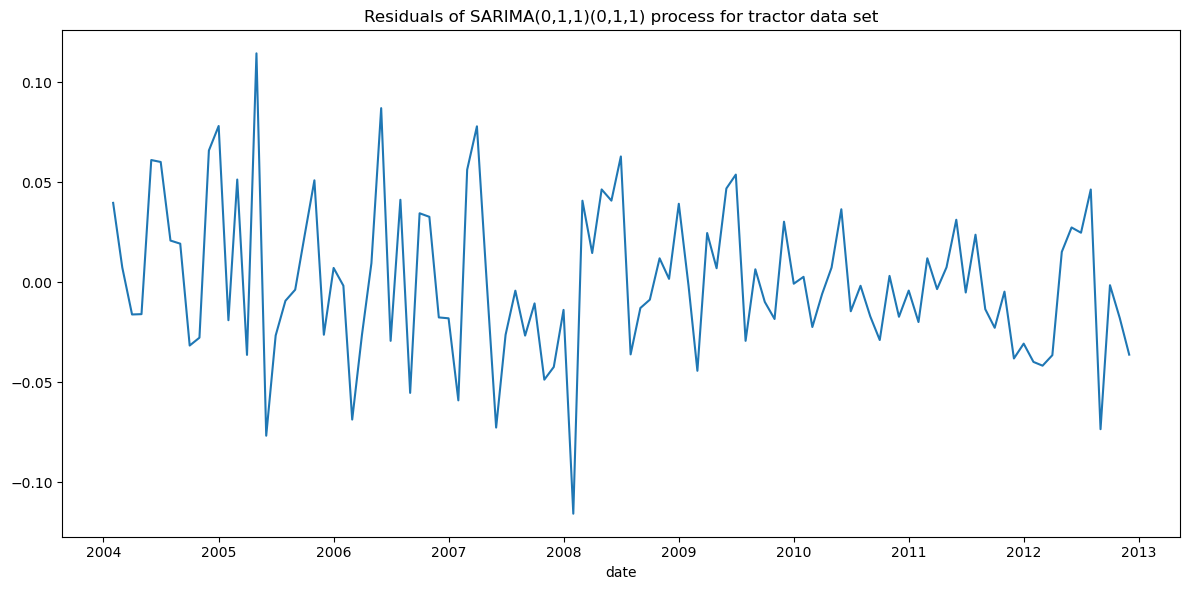

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(sarima.resid()[13:])
plt.title('Residuals of SARIMA(0,1,1)(0,1,1) process for tractor data set')
plt.tight_layout()
plt.show()

ACF and PACF of residuals to check if they resemble white noise

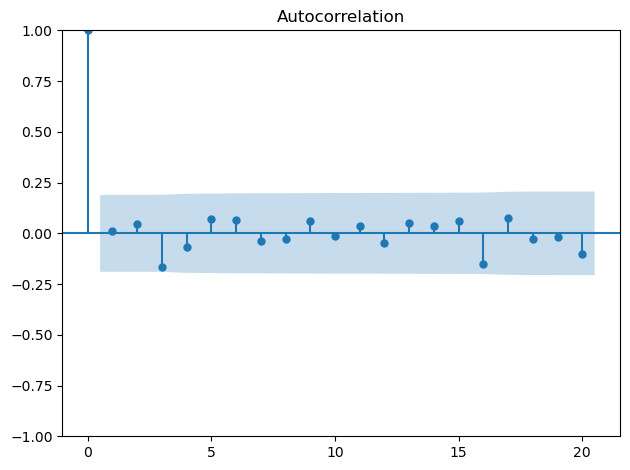

In [6]:
plot_acf(sarima.resid()[13:], lags=20)
plt.tight_layout()
plt.savefig('flightsSARIMA_resid_acf.png', transparent=True)
plt.show()

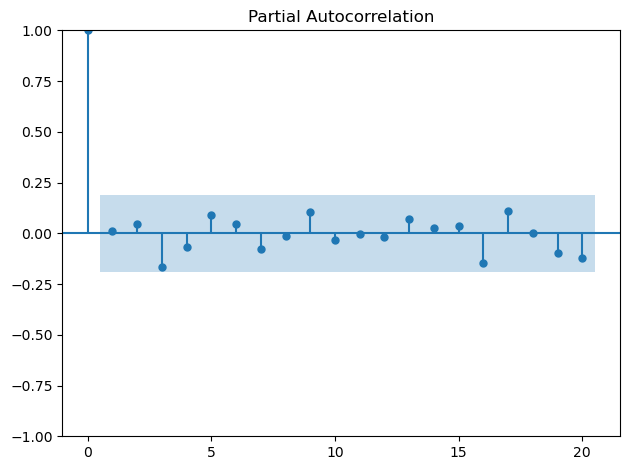

In [7]:
plot_pacf(sarima.resid()[13:], lags=20)
plt.tight_layout()
plt.savefig('flightsSARIMA_resid_pacf.png', transparent=True)
plt.show()

In [8]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(sarima.resid()[13:])

,lb_stat,lb_pvalue
1,0.012194,0.912070
2,0.244470,0.884940
3,3.293267,0.348581
4,3.820456,0.430849
5,4.418483,0.490864
6,4.943227,0.551115
7,5.118674,0.645483
8,5.214390,0.734435
9,5.679805,0.771488
10,5.701694,0.839672


The diagnostics do not speak against the model.

#### 4. Make predictions for the test data. Visualize the result and calculate the RMSE. 

In [9]:
# Create predictions for the future, evaluate on test
sarima_preds, sarima_conf_int = sarima.predict(n_periods=test.shape[0], return_conf_int=True)

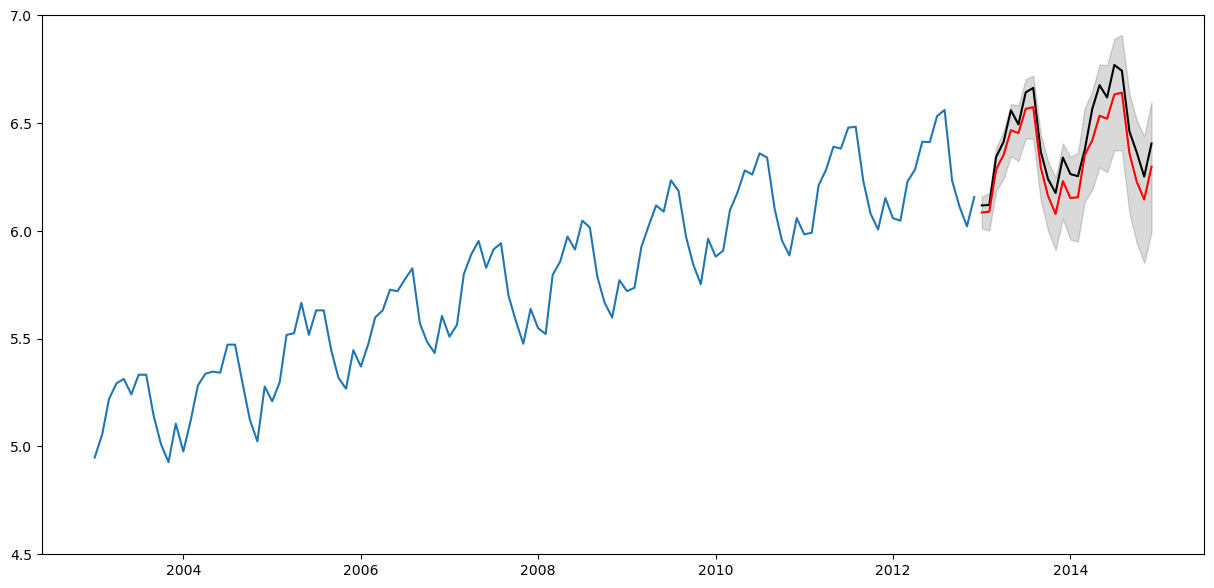

In [10]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(train.log_sold, color='#1f76b4')
plt.plot(test.log_sold, color='black')
# plt.plot(arima_preds, color='blue')    
plt.plot(sarima_preds, color='red')    
# plt.plot(fitted_series, color='darkgreen')
plt.fill_between(test.index, 
                sarima_conf_int[:,0], 
                sarima_conf_int[:,1], 
                color='k', alpha=.15)
plt.ylim([4.5,7])
plt.show()

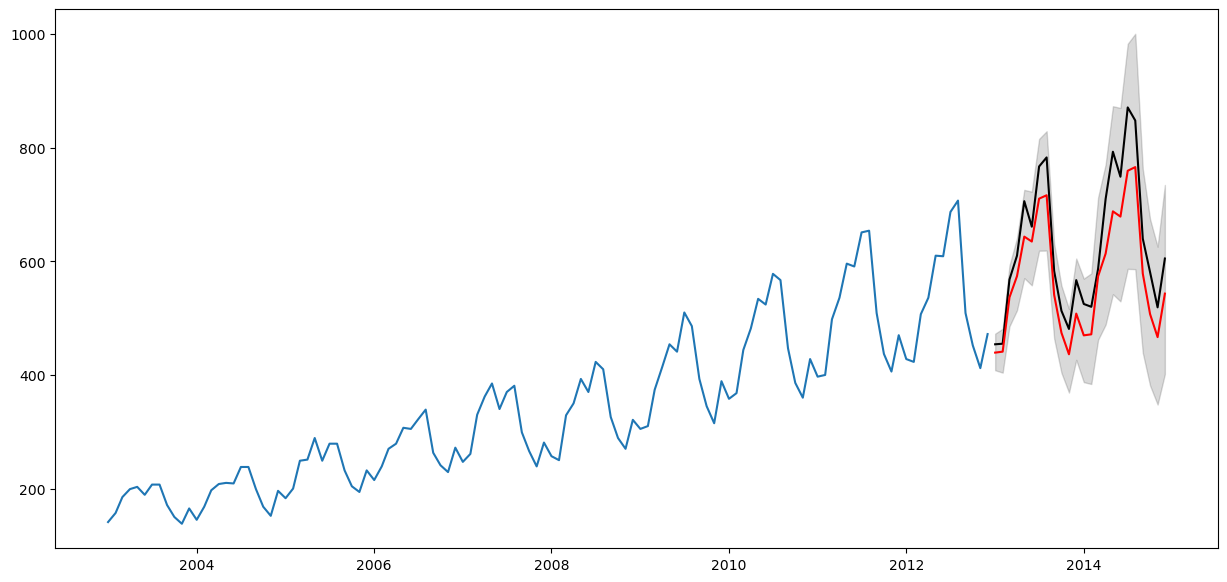

In [11]:
# Plot original series (logarithmicization reversed)
plt.figure(figsize=(15,7))
plt.plot(train.sold, color='#1f76b4')
plt.plot(test.sold, color='black')
# plt.plot(arima_preds, color='blue')    
plt.plot(np.exp(sarima_preds), color='red')    
# plt.plot(fitted_series, color='darkgreen')
plt.fill_between(test.index, 
                np.exp(sarima_conf_int[:,0]), 
                np.exp(sarima_conf_int[:,1]), 
                color='k', alpha=.15)
# plt.ylim([4.5,7])
plt.show()

#### Mean Squared Error
The RMSE confirms that the SARIMA model obviously provides better predictions than the ARIMA model.

In [12]:
# RMSE for log_passengers
print("Test RMSE for SARIMA: %.3f" % np.sqrt(mean_squared_error(test.log_sold, sarima_preds)))

Test RMSE for SARIMA: 0.096
